In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/MyDrive/PyTorch'

/content/drive/MyDrive/PyTorch


In [ ]:
train_path = 'data/Rotten-Tomatoes/train.csv'
test_path = 'data/Rotten-Tomatoes/test.csv'
val_path = 'data/Rotten-Tomatoes/val.csv'

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('data/Rotten-Tomatoes/Train.csv')
df.head()

,Unnamed: 0,PhraseId,SentenceId,Phrase,Sentiment
0,0,98294,5151,`` terrible,0
1,1,20122,894,"Before long , you 're desperate for the evenin...",0
2,2,55614,2777,"particularly joyless , and exceedingly dull",0
3,3,101112,5314,as tiresome as 9 seconds,0
4,4,99492,5217,"cold , grey , antiseptic and emotionally desic...",0


In [ ]:
import os
import random
import time
import string
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchtext
from torchtext import data
import torch.optim as optim
from torchtext.vocab import Vectors
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchsummary import summary

In [ ]:
%time
def load_data(file_path, device):

    tokenizer = lambda x: str(x).translate(str.maketrans('', '', string.punctuation)).strip().split()
    TEXT = data.Field(sequential=True, lower=True, include_lengths=True, tokenize=tokenizer)
    LABEL = data.Field(sequential=False, use_vocab=False)
    
    trn_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    tst_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    val_dataField = [('Unnamed: 0', None), ('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
    
    train = data.TabularDataset(path=os.path.join(file_path, 'Train.csv'), format='csv', skip_header=True, fields=trn_dataField)
    test = data.TabularDataset(path=os.path.join(file_path, 'Test.csv'), format='csv', skip_header=True, fields=tst_dataField)
    valid = data.TabularDataset(path=os.path.join(file_path, 'Val.csv'), format='csv', skip_header=True, fields=val_dataField)
    
    cache = ('/content/drive/MyDrive/PyTorch/.vector_cache')
    if not os.path.exists(cache):
        os.mkdir(cache)

    vector = torchtext.vocab.GloVe('6B',dim=200)

    TEXT.build_vocab(train, vectors=vector, unk_init=torch.Tensor.normal_)
    
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), device=device, batch_size=64, sort_within_batch=True, sort_key = lambda x: len(x.Phrase))
    return TEXT, LABEL, train_iter, valid_iter, test_iter, train


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TEXT, LABEL, train_iter, valid_iter, test_iter, train = load_data('/content/drive/MyDrive/PyTorch/data/Rotten-Tomatoes', device)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


100%|█████████▉| 399417/400000 [00:28<00:00, 14634.15it/s]

In [ ]:
# fancy stuff
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(embedding_size, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        if bidirectional:
            self.fc = nn.Linear(2 * hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, lengths):
        
        embedded = self.embedding(text)   #embedded : [sen_len, batch_size, emb_dim]
        
        packed_embedded = pack_padded_sequence(embedded, lengths.to('cpu'))
        
        # packed_output : [num_word, emb_dim]     hidden : [num_layers * num_direction, batch_size, hid_dim]    
        # cell : [num_layers * num_direction, batch_size, hid_dim]
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        output, output_length = pad_packed_sequence(packed_output)
        
        hidden = self.dropout(torch.cat([hidden[-2,:,:], hidden[-1,:,:]], dim=1)).squeeze()
         # hidden : [batch_size, hid_dim * num_dir]
        return self.fc(hidden)
    
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = SentimentModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [ ]:
len(TEXT.vocab)

16373

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print(TEXT.vocab.vectors.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([16373, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0715,  0.0935,  0.0237,  ...,  0.3362,  0.0306,  0.2558],
        ...,
        [-0.3418,  1.0455,  0.1578,  ..., -0.2159,  0.4236,  1.4846],
        [ 0.5885,  0.2344,  0.0151,  ...,  0.0566, -0.0375,  0.5125],
        [-0.3076,  0.6030, -0.3311,  ...,  0.2374, -0.4458, -0.5565]])

In [ ]:
model.embedding.weight.requires_grad=False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


100%|█████████▉| 399417/400000 [00:40<00:00, 14634.15it/s]

In [ ]:
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def accuracy(preds, y):
    '''
    Return accuracy per batch ..
    '''
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
    correct = (preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, train_iterator, val_iterator, optimizer, loss_function, epochs, results):
  
  for j in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    print(color.BOLD + "Training for epoch = " + color.END, j)
    for i, batch in tqdm(enumerate(train_iterator)):
        
        optimizer.zero_grad()

        text, text_lengths = batch.Phrase

        if(torch.min(text_lengths) <= 0): 
            continue
        #print(text, text_lengths)
        predictions = model(text, text_lengths)
        
        loss = loss_function(predictions, batch.Sentiment)
        
        acc = accuracy(predictions, batch.Sentiment)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    print(f"[{j}/{epochs}] : epoch_loss: {epoch_loss / len(train_iterator):.4f} : epoch_acc: {epoch_acc / len(train_iterator):.4f}")
    val_loss, val_acc = evaluate(model, val_iterator, loss_function)

    train_loss = epoch_loss / len(train_iterator)
    train_acc = epoch_acc / len(train_iterator)
    results = results.append({"Epoch": (j+1), \
                            "Train Loss": train_loss, "Train Accuracy": train_acc, \
                            "Val Loss": val_loss, "Val Accuracy": val_acc},ignore_index=True)
    
    torch.save(model.state_dict(), f"./data/Sentiment_models/model2/glove_model_{j+1}.pth")
    results.to_csv(f"./data/Sentiment_models/model2/glove_Results_{EMBEDDING_DIM}.csv")


  return train_loss, train_acc

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    print("Validation")
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator)):
            
            text, text_lengths = batch.Phrase
            test_lengths = text_lengths.to('cpu')
            if(torch.min(text_lengths) <= 0): 
                continue
            else:
                predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.Sentiment)
        
            acc = accuracy(predictions, batch.Sentiment)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    print(f"val_loss: {epoch_loss / len(iterator):.4f} : val_acc: {epoch_acc / len(iterator):.4f}")
    print("--------------------------------------------------------------------")
    print();print()
    return epoch_loss / len(iterator),  epoch_acc / len(iterator)

In [ ]:
epochs = 60
results = pd.DataFrame(columns=["Epoch","Train Loss","Train Accuracy","Val Loss","Val Accuracy"])
train(model, train_iter, valid_iter, optimizer, loss_function, epochs, results)

Training for epoch =  0



[0/60] : epoch_loss: 0.9757 : epoch_acc: 0.5940
Validation



val_loss: 0.8995 : val_acc: 0.6245
--------------------------------------------------------------------


Training for epoch =  1



[1/60] : epoch_loss: 0.8659 : epoch_acc: 0.6339
Validation



val_loss: 0.8450 : val_acc: 0.6455
--------------------------------------------------------------------


Training for epoch =  2



[2/60] : epoch_loss: 0.7998 : epoch_acc: 0.6585
Validation



val_loss: 0.8084 : val_acc: 0.6622
--------------------------------------------------------------------


Training for epoch =  3



[3/60] : epoch_loss: 0.7452 : epoch_acc: 0.6834
Validation



val_loss: 0.8076 : val_acc: 0.6599
--------------------------------------------------------------------


Training for epoch =  4



[4/60] : epoch_loss: 0.6994 : epoch_acc: 0.7022
Validation



val_loss: 0.7974 : val_acc: 0.6700
--------------------------------------------------------------------


Training for epoch =  5



[5/60] : epoch_loss: 0.6607 : epoch_acc: 0.7192
Validation



val_loss: 0.7970 : val_acc: 0.6710
--------------------------------------------------------------------


Training for epoch =  6



[6/60] : epoch_loss: 0.6259 : epoch_acc: 0.7334
Validation



val_loss: 0.8078 : val_acc: 0.6752
--------------------------------------------------------------------


Training for epoch =  7



[7/60] : epoch_loss: 0.5909 : epoch_acc: 0.7458
Validation



val_loss: 0.8201 : val_acc: 0.6693
--------------------------------------------------------------------


Training for epoch =  8



[8/60] : epoch_loss: 0.5606 : epoch_acc: 0.7582
Validation



val_loss: 0.8616 : val_acc: 0.6722
--------------------------------------------------------------------


Training for epoch =  9



[9/60] : epoch_loss: 0.5300 : epoch_acc: 0.7698
Validation



val_loss: 0.8843 : val_acc: 0.6690
--------------------------------------------------------------------


Training for epoch =  10



[10/60] : epoch_loss: 0.5015 : epoch_acc: 0.7828
Validation



val_loss: 0.9264 : val_acc: 0.6623
--------------------------------------------------------------------


Training for epoch =  11



[11/60] : epoch_loss: 0.4751 : epoch_acc: 0.7934
Validation



val_loss: 0.9625 : val_acc: 0.6585
--------------------------------------------------------------------


Training for epoch =  12



[12/60] : epoch_loss: 0.4520 : epoch_acc: 0.8040
Validation



val_loss: 0.9907 : val_acc: 0.6564
--------------------------------------------------------------------


Training for epoch =  13



[13/60] : epoch_loss: 0.4249 : epoch_acc: 0.8133
Validation



val_loss: 1.0372 : val_acc: 0.6514
--------------------------------------------------------------------


Training for epoch =  14



[14/60] : epoch_loss: 0.4037 : epoch_acc: 0.8254
Validation



val_loss: 1.1006 : val_acc: 0.6562
--------------------------------------------------------------------


Training for epoch =  15



[15/60] : epoch_loss: 0.3824 : epoch_acc: 0.8339
Validation



val_loss: 1.1294 : val_acc: 0.6490
--------------------------------------------------------------------


Training for epoch =  16



[16/60] : epoch_loss: 0.3657 : epoch_acc: 0.8417
Validation



val_loss: 1.1836 : val_acc: 0.6541
--------------------------------------------------------------------


Training for epoch =  17



[17/60] : epoch_loss: 0.3495 : epoch_acc: 0.8486
Validation



val_loss: 1.2428 : val_acc: 0.6520
--------------------------------------------------------------------


Training for epoch =  18



[18/60] : epoch_loss: 0.3352 : epoch_acc: 0.8557
Validation



val_loss: 1.2409 : val_acc: 0.6486
--------------------------------------------------------------------


Training for epoch =  19



[19/60] : epoch_loss: 0.3215 : epoch_acc: 0.8620
Validation



val_loss: 1.3049 : val_acc: 0.6459
--------------------------------------------------------------------


Training for epoch =  20



[20/60] : epoch_loss: 0.3089 : epoch_acc: 0.8657
Validation



val_loss: 1.3567 : val_acc: 0.6423
--------------------------------------------------------------------


Training for epoch =  21



[21/60] : epoch_loss: 0.2993 : epoch_acc: 0.8705
Validation



val_loss: 1.3799 : val_acc: 0.6437
--------------------------------------------------------------------


Training for epoch =  22



[22/60] : epoch_loss: 0.2912 : epoch_acc: 0.8744
Validation



val_loss: 1.3994 : val_acc: 0.6459
--------------------------------------------------------------------


Training for epoch =  23



[23/60] : epoch_loss: 0.2824 : epoch_acc: 0.8784
Validation



val_loss: 1.4048 : val_acc: 0.6449
--------------------------------------------------------------------


Training for epoch =  24



[24/60] : epoch_loss: 0.2702 : epoch_acc: 0.8825
Validation



val_loss: 1.4370 : val_acc: 0.6440
--------------------------------------------------------------------


Training for epoch =  25



[25/60] : epoch_loss: 0.2668 : epoch_acc: 0.8840
Validation



val_loss: 1.5055 : val_acc: 0.6433
--------------------------------------------------------------------


Training for epoch =  26



[26/60] : epoch_loss: 0.2576 : epoch_acc: 0.8875
Validation



val_loss: 1.5179 : val_acc: 0.6447
--------------------------------------------------------------------


Training for epoch =  27



[27/60] : epoch_loss: 0.2512 : epoch_acc: 0.8916
Validation



val_loss: 1.5371 : val_acc: 0.6406
--------------------------------------------------------------------


Training for epoch =  28



[28/60] : epoch_loss: 0.2514 : epoch_acc: 0.8924
Validation



val_loss: 1.6019 : val_acc: 0.6437
--------------------------------------------------------------------


Training for epoch =  29



[29/60] : epoch_loss: 0.2425 : epoch_acc: 0.8946
Validation



val_loss: 1.6107 : val_acc: 0.6386
--------------------------------------------------------------------


Training for epoch =  30



[30/60] : epoch_loss: 0.2369 : epoch_acc: 0.8991
Validation



val_loss: 1.6716 : val_acc: 0.6432
--------------------------------------------------------------------


Training for epoch =  31



[31/60] : epoch_loss: 0.2339 : epoch_acc: 0.8992
Validation



val_loss: 1.5623 : val_acc: 0.6426
--------------------------------------------------------------------


Training for epoch =  32



[32/60] : epoch_loss: 0.2316 : epoch_acc: 0.9003
Validation



val_loss: 1.6643 : val_acc: 0.6397
--------------------------------------------------------------------


Training for epoch =  33



[33/60] : epoch_loss: 0.2272 : epoch_acc: 0.9014
Validation



val_loss: 1.7153 : val_acc: 0.6422
--------------------------------------------------------------------


Training for epoch =  34



[34/60] : epoch_loss: 0.2237 : epoch_acc: 0.9031
Validation



val_loss: 1.7268 : val_acc: 0.6423
--------------------------------------------------------------------


Training for epoch =  35



[35/60] : epoch_loss: 0.2190 : epoch_acc: 0.9043
Validation



val_loss: 1.6981 : val_acc: 0.6400
--------------------------------------------------------------------


Training for epoch =  36



[36/60] : epoch_loss: 0.2182 : epoch_acc: 0.9040
Validation



val_loss: 1.7175 : val_acc: 0.6375
--------------------------------------------------------------------


Training for epoch =  37



[37/60] : epoch_loss: 0.2144 : epoch_acc: 0.9071
Validation



val_loss: 1.7123 : val_acc: 0.6369
--------------------------------------------------------------------


Training for epoch =  38



[38/60] : epoch_loss: 0.2122 : epoch_acc: 0.9073
Validation



val_loss: 1.7180 : val_acc: 0.6371
--------------------------------------------------------------------


Training for epoch =  39



[39/60] : epoch_loss: 0.2104 : epoch_acc: 0.9080
Validation



val_loss: 1.7541 : val_acc: 0.6371
--------------------------------------------------------------------


Training for epoch =  40



[40/60] : epoch_loss: 0.2060 : epoch_acc: 0.9101
Validation



val_loss: 1.7690 : val_acc: 0.6349
--------------------------------------------------------------------


Training for epoch =  41



[41/60] : epoch_loss: 0.2055 : epoch_acc: 0.9098
Validation



val_loss: 1.7718 : val_acc: 0.6333
--------------------------------------------------------------------


Training for epoch =  42



[42/60] : epoch_loss: 0.2044 : epoch_acc: 0.9101
Validation



val_loss: 1.7469 : val_acc: 0.6383
--------------------------------------------------------------------


Training for epoch =  43



[43/60] : epoch_loss: 0.2034 : epoch_acc: 0.9091
Validation



val_loss: 1.7431 : val_acc: 0.6412
--------------------------------------------------------------------


Training for epoch =  44



[44/60] : epoch_loss: 0.2040 : epoch_acc: 0.9095
Validation



val_loss: 1.7864 : val_acc: 0.6378
--------------------------------------------------------------------


Training for epoch =  45



[45/60] : epoch_loss: 0.1988 : epoch_acc: 0.9120
Validation



val_loss: 1.8808 : val_acc: 0.6438
--------------------------------------------------------------------


Training for epoch =  46



[46/60] : epoch_loss: 0.1956 : epoch_acc: 0.9133
Validation



val_loss: 1.9270 : val_acc: 0.6389
--------------------------------------------------------------------


Training for epoch =  47



[47/60] : epoch_loss: 0.1945 : epoch_acc: 0.9133
Validation



val_loss: 1.8694 : val_acc: 0.6352
--------------------------------------------------------------------


Training for epoch =  48



[48/60] : epoch_loss: 0.1944 : epoch_acc: 0.9134
Validation



val_loss: 1.9003 : val_acc: 0.6391
--------------------------------------------------------------------


Training for epoch =  49



[49/60] : epoch_loss: 0.1931 : epoch_acc: 0.9139
Validation



val_loss: 1.7996 : val_acc: 0.6408
--------------------------------------------------------------------


Training for epoch =  50



[50/60] : epoch_loss: 0.1942 : epoch_acc: 0.9146
Validation



val_loss: 1.8606 : val_acc: 0.6415
--------------------------------------------------------------------


Training for epoch =  51



[51/60] : epoch_loss: 0.1918 : epoch_acc: 0.9148
Validation



val_loss: 1.8971 : val_acc: 0.6365
--------------------------------------------------------------------


Training for epoch =  52



[52/60] : epoch_loss: 0.1924 : epoch_acc: 0.9143
Validation



val_loss: 1.8997 : val_acc: 0.6366
--------------------------------------------------------------------


Training for epoch =  53



[53/60] : epoch_loss: 0.1919 : epoch_acc: 0.9155
Validation



val_loss: 1.9487 : val_acc: 0.6371
--------------------------------------------------------------------


Training for epoch =  54



[54/60] : epoch_loss: 0.1905 : epoch_acc: 0.9153
Validation



val_loss: 1.9150 : val_acc: 0.6379
--------------------------------------------------------------------


Training for epoch =  55



[55/60] : epoch_loss: 0.1858 : epoch_acc: 0.9177
Validation



val_loss: 1.9050 : val_acc: 0.6372
--------------------------------------------------------------------


Training for epoch =  56



[56/60] : epoch_loss: 0.1867 : epoch_acc: 0.9156
Validation



val_loss: 1.9768 : val_acc: 0.6359
--------------------------------------------------------------------


Training for epoch =  57



[57/60] : epoch_loss: 0.1861 : epoch_acc: 0.9169
Validation



val_loss: 1.9485 : val_acc: 0.6342
--------------------------------------------------------------------


Training for epoch =  58



[58/60] : epoch_loss: 0.1868 : epoch_acc: 0.9153
Validation



val_loss: 1.9878 : val_acc: 0.6360
--------------------------------------------------------------------


Training for epoch =  59



[59/60] : epoch_loss: 0.1854 : epoch_acc: 0.9162
Validation



val_loss: 1.8868 : val_acc: 0.6357
--------------------------------------------------------------------




(0.1854359980292867, 0.9161633855429182)

In [ ]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sn 

def confusion_matrix(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    pred_y = np.array([])
    true_y = np.array([])
    model.eval()
    print("Testing")
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator)):
            
            text, text_lengths = batch.Phrase
            test_lengths = text_lengths.to('cpu')
            if(torch.min(text_lengths) <= 0): 
                continue
            else:
                predictions = model(text, text_lengths)
            preds = torch.argmax(torch.softmax(predictions, dim=1), dim=1)
            pred_y = np.append(pred_y, preds.detach().cpu().numpy())
            true_y = np.append(true_y, batch.Sentiment.detach().cpu().numpy())
            #print(true_y.shape)
            loss = criterion(predictions, batch.Sentiment)
        
            acc = accuracy(predictions, batch.Sentiment)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    print(f"test_loss: {epoch_loss / len(iterator):.4f} : test_acc: {epoch_acc / len(iterator):.4f}")

    cm = sklearn.metrics.confusion_matrix(true_y, pred_y)
    plt.figure(figsize=(6,4))
    sn.heatmap(cm, annot=True, fmt="d") # font size
    plt.show()

    print("--------------------------------------------------------------------")
    print();print()

Testing



test_loss: 1.9313 : test_acc: 0.6322


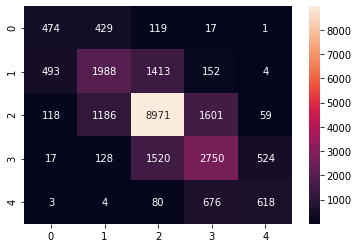

--------------------------------------------------------------------




In [ ]:
confusion_matrix(model, test_iter, loss_function)

In [ ]:
# Plot train and test accuracy and losses

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(f'./data/Sentiment_models/model2/glove_Results_200.csv')
df.head()

,Unnamed: 0,Epoch,Train Loss,Train Accuracy,Val Loss,Val Accuracy
0,0,1.0,0.975666,0.593955,0.899538,0.624476
1,1,2.0,0.865929,0.633853,0.845044,0.645509
2,2,3.0,0.799831,0.658506,0.808380,0.662158
3,3,4.0,0.745212,0.683399,0.807597,0.659908
4,4,5.0,0.699410,0.702205,0.797370,0.670044


In [ ]:
train_loss = df['Train Loss'].values
train_acc = df['Train Accuracy'].values
val_loss = df['Val Loss'].values
val_acc = df['Val Accuracy'].values

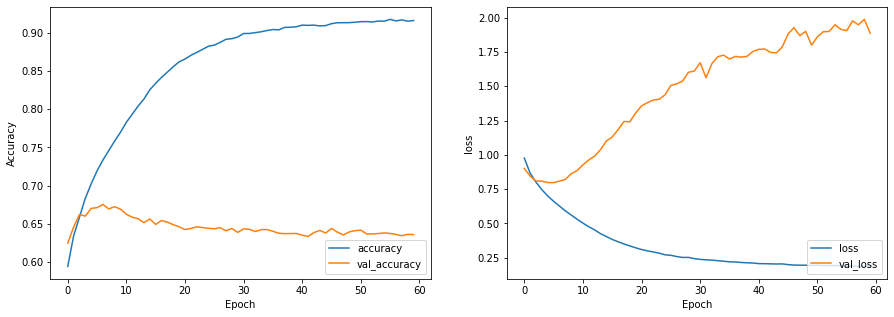

In [ ]:
fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(15,5))

ax1.plot(train_acc, label='accuracy')
ax1.plot(val_acc, label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

ax2.plot(train_loss, label='loss')
ax2.plot(val_loss, label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('loss')
ax2.legend(loc='lower right')

plt.show()